In [2]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import matplotlib.pyplot as plt
import torch 
from tqdm import tqdm
import numpy as np
import os
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
import ast
import pandas as pd
%reload_ext autoreload
%autoreload 2
import seaborn as sns
import json
import matplotlib
font = {"size": 6, "family":"arial"}
matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42

In [3]:
def transform(values):
    values_time = np.zeros((13, 6))
    for i in range(13):
        if i < 3:
            j = 0
        if i >= 3 and i < 11:
            j = 1
        if i >= 11:
            j = 2
        values_time[i] = values[j]
    return values_time

def model_version(log, step_size=400):
    model_info = pd.read_table(f"{log}/model_info.txt", delimiter="      ", engine='python')
    model_info.columns = ["step", "name"]
    df = model_info.groupby("name").max()
    df = df.reset_index()
    df.insert(2, "step_id", (df.step.values / 396).astype("int"))
    results = json.load(open(f"{log}/results.json", "r"))
    last_step = (len(results["trial_type_accuracy"])-1) * 400
    max_trial_acc = np.max(results["trial_type_accuracy"])
    step_trial_type_and_t_trial = df[df.name.str.contains("best_trial_type_t_trial_ratio")].step.values
    if len(step_trial_type_and_t_trial) == 0:
        model_v = "best_trial_type"
        step = df[df.name=="best_trial_type_model.ckpt"].step.values[0]
        return model_v, step, last_step
    
    actual_acc = results["trial_type_accuracy"][step_trial_type_and_t_trial[0]//400]
    if actual_acc == max_trial_acc:
        model_v = "best_trial_type_t_trial_ratio"
        step = step_trial_type_and_t_trial[0]
    else:
        model_v = "best_trial_type"
        step = df[df.name=="best_trial_type_model.ckpt"].step.values[0]
    return model_v, step, last_step


reposition = [(0, 200), (1200,1250), (200,400), (1250, 1300), (400, 600), (1300, 1350), (600, 800), (1350, 1400), (800, 1000), (1400, 1450), (1000, 1200), (1450, 1500)]
r = []
for r1 in reposition:
    r.append([i for i in range(r1[0], r1[1])])
r = np.concatenate(r)
rinv = np.argsort(r)

filtering_time_shrink = 108/650
binning = torch.nn.AvgPool1d(25, stride=1)
bin_areas = torch.nn.AvgPool1d(25, stride=25)

def plot_jaw(jaw, trial, ax, color="black"):
    # plt.axis("off")
    ax.plot(filt(jaw)[:,trial,0].cpu(), color=color, linewidth=0.5)
    ax.axvline(50*filtering_time_shrink, color="gold", linewidth=0.5)
    ax.axvline(550*filtering_time_shrink, color="black", linewidth=0.5)

def plot_grad(light_grads, trial, ax, vmax=None):
    grad = bin_areas(binning((light_grads[:,:,r])[:,trial].cuda().T).T).cpu().detach() * 25 # to account for the avgpool in bin_areas
    if vmax is None:
        im = ax.pcolormesh(grad.T, cmap="bwr", vmin=-grad.abs().max(), vmax=grad.abs().max())
    else:
        im = ax.pcolormesh(grad.T, cmap="bwr", vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    ax.axvline(50, color="gold")
    ax.axvline(550, color="black")
    plt.xticks(np.arange(50, 650,step=100), [f"{i:.1f}" for i in np.arange(50, 650, step=100)/650*1.3-0.1]);
    plt.yticks((np.arange(6)+0.5)*250/25, [opt.areas[i] for i in range(6)]);
    for j in range(6):
        plt.axhline(j*250//25, color="black")

def run_network(model, traps, trials, per_run=200, power=0.1):
    light = torch.zeros(model.T, per_run, model.opt.n_units, device="cuda")
    for trap, trial in zip(traps, trials):
        time = [int((j+0.1)/0.002) for j in trap[1]]
        light[time[0]:time[1], trial, trap[0][0]:trap[0][1]+1] = power
    stims = torch.ones(200).cuda()
    torch.manual_seed(200/per_run-1)
    with torch.no_grad():
        _, _, jaw_light, _ = model(stims, light=light)
    filt_jaw_light = model.filter_fun2(model.filter_fun1(jaw_light))    
    lick_light = lick_classifier(filt_jaw_light[-response_time:,:,0].T)
    return jaw_light, lick_light

In [3]:
os.chdir("..")

In [4]:
areas = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"]
def df_to_hitrate(df):
    hit_rate = np.zeros((df.period.nunique(), len(areas), df.session.nunique()))
    for j, period in enumerate(['off', 'whisker', 'delay', 'response']):
        for i, area in enumerate(areas):
            for k, seed in enumerate(df.session.unique()):
                prop = df[(df.area == area) & (df.period == period) & (df.session == seed)].propabilities.values[0]
                hit_rate[j, i, k] = prop[1] / sum(prop[:2])
    return hit_rate

def dfdata_to_hitrate(df):
    windows = ["Control", "Stim", "Post", "Response"]
    hit_rate = np.zeros((len(windows), len(areas), df.mouse.nunique())) -1
    for j, period in enumerate(windows):
        for i, area in enumerate(areas):
            for k, mouse in enumerate(df.mouse.unique()):
                prop = df[(df.area == area) & (df.win == period) & (df.mouse == mouse)].groupby("mouse").Hit.mean().values
                hit_rate[j, i, k] = prop
    return hit_rate

def der_map(table, resolution, num_areas=6):
    windows = [(-0.1, 0.2), (0.2, 1), (1, 1.2)]
    map_der = np.zeros((int(1.3//0.002//resolution), num_areas))
    tr = lambda x: int((x-opt.start) // model.timestep // resolution)
    for i, window in enumerate(windows):
        map_der[tr(window[0]):tr(window[1])] = table[i]
    return map_der



df_data = pd.read_csv("datasets/opto_data.csv")
hit_rate_data = dfdata_to_hitrate(df_data).mean(2)

In [ ]:
logs = [
    # Best model
    "AllModels/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_39_l1across200_seed1",
    "AllModels/37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_7_26_l1across200_seed0"
]

models = []
for log_path in logs:
    opt = load_training_opt(log_path)
    results = json.load(open(f"{log_path}/results.json", "r"))
    version, step, last_step = model_version(log_path[7:], "")
    step = step//400
    print(step)
    print(results["total_train_loss"][step],results["test_loss"][step], results["trial_type_accuracy"][step])
    opt.spike_derivative = True
    m = load_model_and_optimizer(opt, reload=True, last_best=version)[0]
    models.append(m)
sign = m.rsnn.excitatory_index * 2. - 1

21
1.9339618384838104 39.46501922607422 0.75
42
1.3711632657051087 69.80635070800781 0.75


In [6]:
response_time = 12#int(0.15 / models[0].timestep / (opt.psth_filter / 2))
seed = 1 #logs[0][-1]
lick_classifier = torch.load(f"datasets/QuickAccess/lick_classifie_seed{seed}.pt")
lick_classifier = lick_classifier.to("cuda")# load the data 

# Experimental Suggestion μPerturbations

In [7]:
trials = 200
per_run = 200
model = models[0]
power = 0.1
filt = lambda x: model.filter_fun2(model.filter_fun1(x))
model.zero_grad()
model.opt.batch_size = per_run
model.rsnn.light_neuron[:] = True
light = torch.zeros(model.T, per_run, model.opt.n_units).cuda()
light.requires_grad_()
stims = torch.ones(per_run).cuda()
torch.manual_seed(trials/per_run-1)
spikes, _, jaw, _ = model(stims, light=light)
filt_jaw = model.filter_fun2(model.filter_fun1(jaw))
lick = lick_classifier(filt_jaw[-response_time:,:,0].T)
trial_type = stims * 2 + (lick.detach() > 0.5)[:,0]
# filt_jaw.sum().backward()
lick.sum().backward()
# spike_grads = torch.cat([model.rsnn.spike_list[i].grad for i in range(len(model.rsnn.spike_list))], 0).detach()
light_grads_lick = light.grad.detach()

OutOfMemoryError: CUDA out of memory. Tried to allocate 744.00 MiB (GPU 0; 31.74 GiB total capacity; 87.91 MiB already allocated; 585.62 MiB free; 98.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# torch.save(light_grads_lick, "datasets/QuickAccess/light_grads_lick_spike.pt")
# torch.save(light_grads_jaw, "datasets/QuickAccess/light_grads_jaw_spike.pt")
# light_grads_lick = torch.load("datasets/QuickAccess/light_grads_lick.pt")
# light_grads_jaw = torch.load("datasets/QuickAccess/light_grads_jaw.pt")
light_grads_lick = torch.load("datasets/QuickAccess/light_grads_lick_spike.pt")
light_grads_jaw = torch.load("datasets/QuickAccess/light_grads_jaw_spike.pt")

In [ ]:
# logs = [
#     "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_54_10_l1across200_seed0",
#     "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_39_l1across200_seed1",
#     "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_37_l1across200_seed2",
#     "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_0_57_l1across200_seed3",
#     "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_3_20_l1across200_seed4",
#     "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_3_20_l1across200_seed5",
#     ]
# hit_rate_all = np.zeros((3, 6))
# for log in logs:
#     hit_rate = pd.read_csv(f"OptoEffect/Power1_shorter_filt/opto_effect_{logs[0].split('/')[-1]}.csv")
#     hit_rate.propabilities = hit_rate.propabilities.apply(lambda s: list(ast.literal_eval(s)))
#     hit_rate = df_to_hitrate(hit_rate).mean(2)
#     hit_rate = hit_rate[1:] - hit_rate[0]
#     hit_rate_all += hit_rate / len(logs)


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


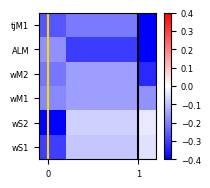

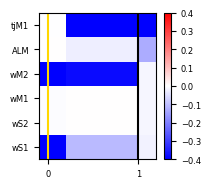

In [ ]:
v_saturation = 0.4

df_data = pd.read_csv("datasets/opto_data.csv")
df_data = df_data.groupby(["mouse", "win", "area"]).Hit.mean().groupby(["win", "area"]).mean()
df_data = pd.pivot_table(df_data.reset_index(), index="win", columns="area", values="Hit")
values = df_data.loc[["Control", "Stim", "Post", "Response"], model.opt.areas].values
values = values[1:] - values[0]
values_time = transform(values)
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(values_time.T, cmap="bwr", vmin=-v_saturation, vmax=v_saturation)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([1,11])
ax.set_xticklabels(["0", "1"])
ax.axvline(1, color="gold")
ax.axvline(11, color="black")
plt.colorbar(im)
fig.savefig("FiguresOpto/Figure4/HitRateData.pdf")

hit_rate = pd.read_csv(f"OptoEffect/Power1_shorter_filt1/opto_effect_{logs[1].split('/')[-1]}.csv")
hit_rate.propabilities = hit_rate.propabilities.apply(lambda s: list(ast.literal_eval(s)))
hit_rate = df_to_hitrate(hit_rate).mean(2)
hit_rate = hit_rate[1:] - hit_rate[0]
values_time = transform(hit_rate)
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(values_time.T, cmap="bwr", vmin=-v_saturation, vmax=v_saturation)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([1,11])
ax.set_xticklabels(["0", "1"])
ax.axvline(1, color="gold")
ax.axvline(11, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_spike.pdf")


In [ ]:
area_limits_inh = {"wS1": [1200, 1250], "wS2": [1250, 1300], "wM1": [1300, 1350], "wM2": [1350, 1400], "ALM": [1400, 1450], "tjM1": [1450, 1500]}
area_limits_exc = {"wS1": [0, 200], "wS2": [200, 400], "wM1": [400, 600], "wM2": [600, 800], "ALM": [800, 1000], "tjM1": [1000, 1200]}
torch.cuda.empty_cache()
trials = 200
micro_map_jaw_exp = torch.zeros(3, 6)
micro_map_lick_exp = torch.zeros(3, 6)
with torch.no_grad():
    for i, time in enumerate([(-0.1, 0.2), (0.2, 1), (1, 1.2)]):
        for area in model.opt.areas:
            timestart = time[0]
            timestop = time[1]
            timestart, timestop = int((timestart - opt.start)//model.timestep), int((timestop - opt.start)//model.timestep)-1
            light = torch.zeros(model.T, per_run, opt.n_units, device="cuda")
            light[timestart:timestop, :, area_limits_inh[area][0]:area_limits_inh[area][1]] = power
            if timestop < 649:
                a = light[timestop-50:timestop, :, area_limits_inh[area][0]:area_limits_inh[area][1]].T
                light[timestop-50:timestop, :, area_limits_inh[area][0]:area_limits_inh[area][1]] = (a - torch.arange(50,device="cuda")/50*power).T
            light[::2] = 0
            model.opt.batch_size = per_run
            torch.manual_seed(trials//per_run-1)
            stims = torch.ones(per_run).cuda()
            spikes_light, _, jaw_light, _ = model(stims, light=light)
            filt_jaw_light = model.filter_fun2(model.filter_fun1(jaw_light))
            lick_light = lick_classifier(filt_jaw_light[-response_time:,:,0].T)
            micro_map_lick_exp[i, model.opt.areas.index(area)] = (lick_light - lick).mean().item()
            micro_map_jaw_exp[i, model.opt.areas.index(area)] = (filt_jaw_light - filt_jaw).sum((0,2)).mean().item()

/tmp/ipykernel_175234/730782653.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3571.)
  a = light[timestop-50:timestop, :, area_limits_inh[area][0]:area_limits_inh[area][1]].T


In [ ]:
micro_map_jaw_exp

tensor([[ -4.3074,  -1.3702,   2.3820,   6.4773, -20.6129, -19.0445],
        [ -5.0565,   1.5431,   0.7340,  -1.6949, -15.4986, -26.1752],
        [ -2.7736,  -2.1136,  -1.4423,  -1.9229,  -2.0025, -12.3626]])

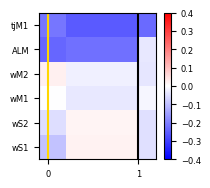

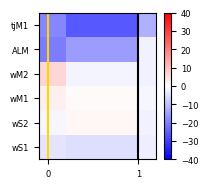

In [ ]:
v_saturation = 0.4
values_time = transform(micro_map_lick_exp)
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(values_time.T, cmap="bwr", vmin=-v_saturation, vmax=v_saturation)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([1,11])
ax.set_xticklabels(["0", "1"])
ax.axvline(1, color="gold")
ax.axvline(11, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_lick_spike.png", transparent=True, dpi=300, bbox_inches="tight")

v_saturation = 40
values_time = transform(micro_map_jaw_exp)
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(values_time.T, cmap="bwr", vmin=-v_saturation, vmax=v_saturation)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([1,11])
ax.set_xticklabels(["0", "1"])
ax.axvline(1, color="gold")
ax.axvline(11, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_jaw_spike.png", transparent=True, dpi=300, bbox_inches="tight")

In [ ]:
area_limits_inh = {"wS1": [1200, 1250], "wS2": [1250, 1300], "wM1": [1300, 1350], "wM2": [1350, 1400], "ALM": [1400, 1450], "tjM1": [1450, 1500]}
area_limits_exc = {"wS1": [0, 200], "wS2": [200, 400], "wM1": [400, 600], "wM2": [600, 800], "ALM": [800, 1000], "tjM1": [1000, 1200]}
torch.cuda.empty_cache()
trials = 200
timepoints = 13
micro_map_jaw = torch.zeros(timepoints, 6*2)
micro_map_lick = torch.zeros(timepoints, 6*2)
timelight = 1.3 / timepoints
with torch.no_grad():
    for time in tqdm(range(timepoints)):
        for area in model.opt.areas:
            for exc in [1]:
                timestart = time * timelight + model.opt.start
                timestop = timestart + timelight 
                timestart, timestop = int((timestart - opt.start)//model.timestep), int((timestop - opt.start)//model.timestep)-1
                light = torch.zeros(model.T, per_run, opt.n_units, device="cuda")
                if exc == 1:
                    light[timestart:timestop, :, area_limits_inh[area][0]:area_limits_inh[area][1]] = power
                else:
                    light[timestart:timestop, :, area_limits_exc[area][0]:area_limits_exc[area][1]] = power
                model.opt.batch_size = per_run
                torch.manual_seed(trials//per_run-1)
                stims = torch.ones(per_run).cuda()
                spikes_light, _, jaw_light, _ = model(stims, light=light)
                filt_jaw_light = model.filter_fun2(model.filter_fun1(jaw_light))
                lick_light = lick_classifier(filt_jaw_light[-response_time:,:,0].T)
                micro_map_lick[time, model.opt.areas.index(area)*2+exc] = (lick_light - lick).mean().item()
                micro_map_jaw[time, model.opt.areas.index(area)*2+exc] = (filt_jaw_light - filt_jaw).sum((0,2)).mean().item()

 85%|████████▍ | 11/13 [03:10<01:04, 32.17s/it]

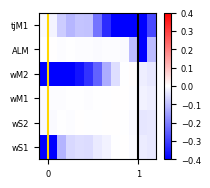

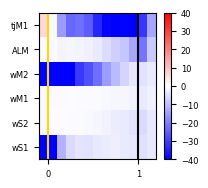

In [ ]:
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(micro_map_lick[:,1::2].T, cmap="bwr", vmin=-0.4, vmax=0.4)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([1,11])
ax.set_xticklabels(["0", "1"])
ax.axvline(1, color="gold")
ax.axvline(11, color="black")

fig.savefig("FiguresOpto/Figure4/HitRateModel_dt100ms_spike.png", transparent=True, dpi=300, bbox_inches="tight")

fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(micro_map_jaw[:,1::2].T, cmap="bwr", vmin=-40, vmax=40)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([1,11])
ax.set_xticklabels(["0", "1"])
ax.axvline(1, color="gold")
ax.axvline(11, color="black")

fig.savefig("FiguresOpto/Figure4/HitRateModel_dt100ms_jaw_spike.png", transparent=True, dpi=300, bbox_inches="tight")

In [ ]:
area_limits_inh = {"wS1": [1200, 1250], "wS2": [1250, 1300], "wM1": [1300, 1350], "wM2": [1350, 1400], "ALM": [1400, 1450], "tjM1": [1450, 1500]}
area_limits_exc = {"wS1": [0, 200], "wS2": [200, 400], "wM1": [400, 600], "wM2": [600, 800], "ALM": [800, 1000], "tjM1": [1000, 1200]}
torch.cuda.empty_cache()
trials = 200
timepoints = 26
micro_map_jaw_50 = torch.zeros(timepoints, 6*2)
micro_map_lick_50 = torch.zeros(timepoints, 6*2)
timelight = 1.3 / timepoints
with torch.no_grad():
    for time in tqdm(range(timepoints)):
        for area in model.opt.areas:
            for exc in [0,1]:
                timestart = time * timelight + model.opt.start
                timestop = timestart + timelight 
                timestart, timestop = int((timestart - opt.start)//model.timestep), int((timestop - opt.start)//model.timestep)-1
                light = torch.zeros(model.T, per_run, opt.n_units, device="cuda")
                if exc == 1:
                    light[timestart:timestop, :, area_limits_inh[area][0]:area_limits_inh[area][1]] = power
                else:
                    light[timestart:timestop, :, area_limits_exc[area][0]:area_limits_exc[area][1]] = power
                model.opt.batch_size = per_run
                torch.manual_seed(trials//per_run-1)
                stims = torch.ones(per_run).cuda()
                spikes_light, _, jaw_light, _ = model(stims, light=light)
                filt_jaw_light = model.filter_fun2(model.filter_fun1(jaw_light))
                lick_light = lick_classifier(filt_jaw_light[-response_time:,:,0].T)
                micro_map_lick_50[time, model.opt.areas.index(area)*2+exc] = (lick_light - lick).mean().item()
                micro_map_jaw_50[time, model.opt.areas.index(area)*2+exc] = (filt_jaw_light - filt_jaw).sum((0,2)).mean().item()

100%|██████████| 26/26 [05:47<00:00, 13.36s/it]


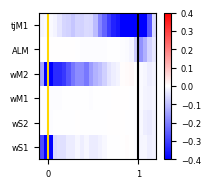

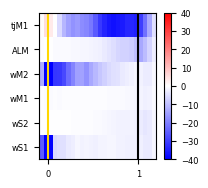

In [ ]:
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(micro_map_lick_50[:,1::2].T, cmap="bwr", vmin=-0.4, vmax=0.4)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([2,22])
ax.set_xticklabels(["0", "1"])
ax.axvline(2, color="gold")
ax.axvline(22, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_dt50ms_spike.png", transparent=True, dpi=300, bbox_inches="tight")

fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(micro_map_jaw_50[:,1::2].T, cmap="bwr", vmin=-40, vmax=40)
plt.colorbar(im)
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(model.opt.areas)
ax.set_xticks([2,22])
ax.set_xticklabels(["0", "1"])
ax.axvline(2, color="gold")
ax.axvline(22, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_dt50ms_jaw_spike.png", transparent=True, dpi=300, bbox_inches="tight")

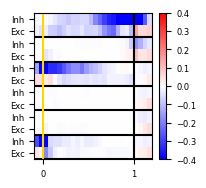

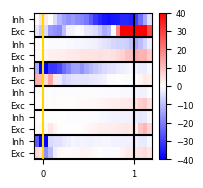

In [ ]:
fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(micro_map_lick_50.T, cmap="bwr", vmin=-0.4, vmax=0.4)
plt.colorbar(im)
ax.set_yticks(np.arange(12)+0.5)
ax.set_yticklabels(["Exc" if i%2==0 else "Inh" for i in range(12)])
ax.set_xticks([2,22])
ax.set_xticklabels(["0", "1"])
for i in range(6):
    ax.axhline(i*2, color="black")
ax.axvline(2, color="gold")
ax.axvline(22, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_dt50ms_ei_spike.png", transparent=True, dpi=300, bbox_inches="tight")


fig, ax = plot_with_size(37.5, 37.5)
im = plt.pcolormesh(micro_map_jaw_50.T, cmap="bwr", vmin=-40, vmax=40)
plt.colorbar(im)
ax.set_yticks(np.arange(12)+0.5)
ax.set_yticklabels(["Exc" if i%2==0 else "Inh" for i in range(12)])
ax.set_xticks([2,22])
ax.set_xticklabels(["0", "1"])
for i in range(6):
    ax.axhline(i*2, color="black")
ax.axvline(2, color="gold")
ax.axvline(22, color="black")
fig.savefig("FiguresOpto/Figure4/HitRateModel_dt50ms_ei_jaw_spike.png", transparent=True, dpi=300, bbox_inches="tight")

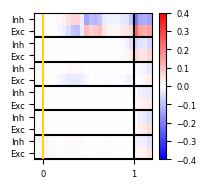

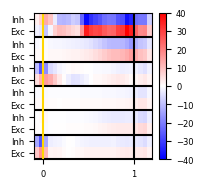

In [ ]:
binning_50 = torch.nn.AvgPool1d(25, stride=25)
fig, ax = plot_with_size(37.5, 37.5)
bined_grads_lick = torch.zeros_like(micro_map_lick_50)
for i in range(6):
    bined_grads_lick[:,i*2] = binning_50(light_grads_lick.T).T.mean(1)[:,i*200:(i+1)*200].sum(1) * power * (timelight / model.timestep)
    bined_grads_lick[:,i*2+1] = binning_50(light_grads_lick.T).T.mean(1)[:,(1200+i*50):(1200+(i+1)*50)].sum(1) * power * (timelight / model.timestep)
im = plt.pcolormesh(bined_grads_lick.T, cmap="bwr", vmin=-0.4, vmax=0.4)
plt.colorbar(im)
ax.set_xticks([2,22])
ax.set_xticklabels(["0", "1"])
for i in range(6):
    ax.axhline(i*2, color="black")
ax.axvline(2, color="gold")
ax.axvline(22, color="black")
ax.set_yticks(np.arange(12)+0.5)
ax.set_yticklabels(["Exc" if i%2==0 else "Inh" for i in range(12)])
fig.savefig("FiguresOpto/Figure4/lick_grad_spike.png", transparent=True, dpi=300, bbox_inches="tight")

binning_50 = torch.nn.AvgPool1d(25, stride=25)
fig, ax = plot_with_size(37.5, 37.5)
bined_grads = torch.zeros_like(micro_map_lick_50)
for i in range(6):
    bined_grads[:,i*2] = (binning_50(light_grads_jaw.T).T.mean(1))[:,i*200:(i+1)*200].sum(1) * power * (timelight / model.timestep)
    bined_grads[:,i*2+1] = (binning_50(light_grads_jaw.T).T.mean(1))[:,(1200+i*50):(1200+(i+1)*50)].sum(1) * power * (timelight / model.timestep)
im = plt.pcolormesh(bined_grads.T, cmap="bwr", vmin=-40, vmax=40)
plt.colorbar(im)
ax.set_xticks([2,22])
ax.set_xticklabels(["0", "1"])
for i in range(6):
    ax.axhline(i*2, color="black")
ax.axvline(2, color="gold")
ax.axvline(22, color="black")
ax.set_yticks(np.arange(12)+0.5)
ax.set_yticklabels(["Exc" if i%2==0 else "Inh" for i in range(12)])
fig.savefig("FiguresOpto/Figure4/jaw_grad_spike.png", transparent=True, dpi=300, bbox_inches="tight")

In [ ]:
# trials = torch.arange(200)[lick[:,0].cpu() < 0.5]
# for i, trial in enumerate(trials[:20]):
#     fig, ax = plot_with_size(37.5, 37.5)
#     im = plt.pcolormesh(bin_areas(binning((light_grads[:,:,r])[:,trial].cuda().T).T).cpu().detach(), cmap="bwr")
#     im = plt.pcolormesh(light_grads_jaw[:,trial,r].cpu().T, cmap="bwr",vmin=-0.3, vmax=0.3)
#     ax.set_xticklabels([f"{i*model.timestep*650/6+opt.start:.2f}" for i in range(6)])
#     ax.set_xticks([650/6*i for i in range(6)])

#     # plot_grad(light_grads_lick/model.timestep, trial, ax, vmax=0.04)
#     # ax.set_title(f"{trial} {lick[trial].item():.3f}")
#     # fig, ax = plot_with_size(37.5, 37.5)
#     # plot_grad(light_grads_jaw/model.timestep, trial, ax, vmax=200)   
#     ax.set_title(f"{trial} {lick[trial].item():.3f}")

[((825, 875), (0.5, 0.7)), ((1450, 1500), (0.8, 0.9)), ((850, 911), (0.8, 0.9)), ((850, 900), (0.22, 0.35))]
tensor([0.0036], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0040], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.9877], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0042], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.6361], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0047], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.9926], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.6095], device='cuda:0', grad_fn=<SelectBackward0>)


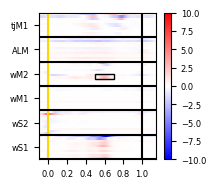

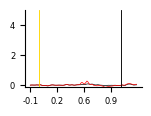

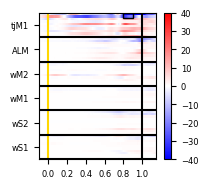

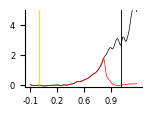

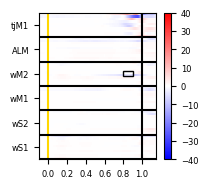

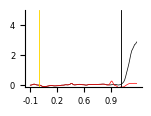

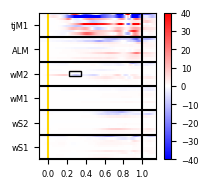

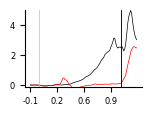

In [ ]:
# For the no spike version
traps = [[(675, 724),(0.5, 0.7)], [(1450, 1499),(0.8, 0.9)], [(700,760), (0.8, 0.9)], [(700,749), (0.22, 0.35)]]
traps_inv = [((rinv[i[0]], rinv[i[1]]+1), j) for i,j in traps]
print(traps_inv)
trials = [41,  9, 3, 22]
jaw_light, lick_light = run_network(model, traps, trials, power=0.3)
for i, trial in enumerate(trials):
    time = [int((j+0.1)/0.002) for j in traps[i][1]]
    print(lick[trial], lick_light[trial])
    neurons = traps_inv[i][0]
    n_bined = [int(j/25) for j in neurons]
    fig, ax = plot_with_size(37.5, 37.5)
    if lick[trial,0].item() < 0.5:
        plot_grad(light_grads_jaw * power * (timelight / model.timestep), trial, ax, vmax=10)
    else:
        plot_grad(light_grads_jaw * power * (timelight / model.timestep), trial, ax, vmax=40)
    rect = plt.Rectangle((time[0], n_bined[0]), time[1]-time[0], n_bined[1]-n_bined[0], edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.savefig(f"FiguresOpto/Figure4/jaw_grad_effect_trial{trial}.png", transparent=True, dpi=300, bbox_inches="tight")
    
    
    fig, ax = plot_with_size(30, 20)
    strip_right_top_axis(ax)
    plot_jaw(jaw.detach(), trial, ax, color="black")
    plot_jaw(jaw_light, trial, ax, color="red")
    plt.xticks(np.arange(0, 108, step=27), [f"{i:.1f}" for i in np.arange(0, 108, step=27)/108*1.3-0.1])
    plt.ylim(-0.15, 5)
    plt.savefig(f"FiguresOpto/Figure4/jaw_effect_trial{trial}.pdf")

In [ ]:
# For the spike version
from tqdm import tqdm
light_grads = light_grads_jaw
trials = 200
area_limits_inh = {"wS1": [1200, 1250], "wS2": [1250, 1300], "wM1": [1300, 1350], "wM2": [1350, 1400], "ALM": [1400, 1450], "tjM1": [1450, 1500]}
area_limits_exc = {"wS1": [0, 200], "wS2": [200, 400], "wM1": [400, 600], "wM2": [600, 800], "ALM": [800, 1000], "tjM1": [1000, 1200]}
torch.cuda.empty_cache()
pos_modul = [] #[[] for i in range(13)]
neg_modul = [] #[[] for i in range(13)]
rand_modul = [] #[[] for i in range(13)]
num_neurons = 20
np.random.seed(1)
with torch.no_grad():
    for modulation in [1, -1, 0]:
        for time in tqdm(range(13)):
            timestart = time * 0.1 + model.opt.start
            timestop = timestart + 0.1
            timestart, timestop = int((timestart - opt.start)//model.timestep), int((timestop - opt.start)//model.timestep)
            light = torch.zeros(model.T, per_run, opt.n_units, device="cuda")

            if modulation == 1:
                pos_modulated = light_grads[timestart:timestop,:].mean(0)
                mod_neurons = pos_modulated.argsort()[:, -num_neurons:]
                important_trials = []
                for trial in range(per_run):
                    if pos_modulated[trial, mod_neurons[trial]].sum() > 0.5 and (pos_modulated[trial, mod_neurons[trial]] > 0).all():
                        light[timestart:timestop, trial, mod_neurons[trial]] = power
                        important_trials.append(trial)
                important_trials = torch.tensor(important_trials)
            elif modulation == -1:
                neg_modulated = light_grads[timestart:timestop,:].mean(0)
                mod_neurons = neg_modulated.argsort()[:, :num_neurons]
                important_trials = []
                for trial in range(per_run):
                    if neg_modulated[trial, mod_neurons[trial]].sum() < -0.5 and (neg_modulated[trial, mod_neurons[trial]] < 0).all():
                        light[timestart:timestop, trial, mod_neurons[trial]] = power
                        important_trials.append(trial)
                important_trials = torch.tensor(important_trials)

            elif modulation == 0:
                important_trials = torch.arange(per_run)
                for trial in range(per_run):
                    mod_neurons = np.random.randint(1500, size=(num_neurons))
                    light[timestart:timestop, trial, mod_neurons] = power
            model.opt.batch_size = per_run
            torch.manual_seed(trials//per_run-1)
            stims = torch.ones(per_run).cuda()
            spikes_light, _, jaw_light, _ = model(stims, light=light)
            filt_jaw_light = model.filter_fun2(model.filter_fun1(jaw_light))
            if modulation == 1:
                pos_modul += (filt_jaw_light - filt_jaw)[:, important_trials].sum((0,2)).tolist()
            elif modulation == -1:
                neg_modul += (filt_jaw_light - filt_jaw)[:, important_trials].sum((0,2)).tolist()
            elif modulation == 0:
                rand_modul += (filt_jaw_light - filt_jaw)[:, important_trials].sum((0,2)).tolist()
            

100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


41.33053548891525 -6.8993966729011245 -33.51231177797684


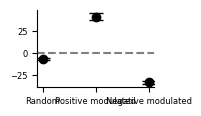

In [ ]:
print(np.mean(pos_modul), np.mean(rand_modul), np.mean(neg_modul))
fig, ax = plot_with_size(30, 20)
plt.errorbar([0], [np.mean(rand_modul)], [1.96*np.std(rand_modul)/np.sqrt(len(rand_modul))], fmt="o", label="Random modulation", color="black", capsize=5)
plt.errorbar([1], [np.mean(pos_modul)], [1.96*np.std(pos_modul)/np.sqrt(len(pos_modul))], fmt="o", label="Positive modulation", color="black", capsize=5)
plt.errorbar([2], [np.mean(neg_modul)], [1.96*np.std(neg_modul)/np.sqrt(len(neg_modul))], fmt="o", label="Negative modulation", color="black", capsize=5)
plt.xticks(np.arange(3), ["Random", "Positive modulated", "Negative modulated"])
strip_right_top_axis(ax)
plt.axhline(0, color="grey", linestyle="--")
fig.savefig("FiguresOpto/Figure4/jaw_modulation_nospike.pdf")

48.79875814815402 -0.30103331978647757 -22.780762461723846


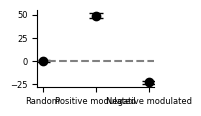

In [ ]:
print(np.mean(pos_modul), np.mean(rand_modul), np.mean(neg_modul))
fig, ax = plot_with_size(30, 20)
plt.errorbar([0], [np.mean(rand_modul)], [1.96*np.std(rand_modul)/np.sqrt(len(rand_modul))], fmt="o", label="Random modulation", color="black", capsize=5)
plt.errorbar([1], [np.mean(pos_modul)], [1.96*np.std(pos_modul)/np.sqrt(len(pos_modul))], fmt="o", label="Positive modulation", color="black", capsize=5)
plt.errorbar([2], [np.mean(neg_modul)], [1.96*np.std(neg_modul)/np.sqrt(len(neg_modul))], fmt="o", label="Negative modulation", color="black", capsize=5)
plt.xticks(np.arange(3), ["Random", "Positive modulated", "Negative modulated"])
strip_right_top_axis(ax)
plt.axhline(0, color="grey", linestyle="--")
# fig.savefig("FiguresOpto/Figure4/jaw_modulation.pdf")

tensor([0.0069], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0061], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0060], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7304], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.9905], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0045], device='cuda:0', grad_fn=<SelectBackward0>)


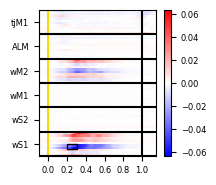

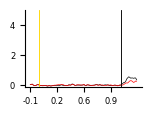

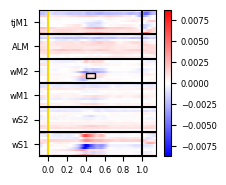

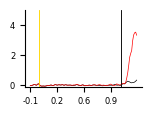

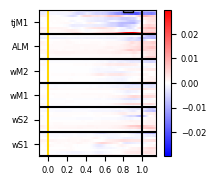

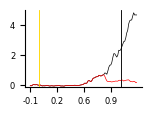

In [ ]:
# For the spiking model logs[0], I keep this here for supplementary
traps = [[(75, 124),(0.2, 0.3)], [(650, 699), (0.4, 0.5)], [(1450, 1499),(0.8, 0.9)]]
traps_inv = [((rinv[i[0]], rinv[i[1]]+1), j) for i,j in traps]
trials = [2,13,20]
jaw_light, lick_light = run_network(model, traps, trials, power=0.3)

for i, trial in enumerate(trials):
    time = [int((j+0.1)/0.002) for j in traps[i][1]]
    print(lick[trial], lick_light[trial])
    neurons = traps_inv[i][0]
    n_bined = [int(j/25) for j in neurons]
    fig, ax = plot_with_size(37.5, 37.5)
    plot_grad(light_grads_jaw, trial, ax)
    rect = plt.Rectangle((time[0], n_bined[0]), time[1]-time[0], n_bined[1]-n_bined[0], edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    plt.savefig(f"FiguresOpto/Figure4/jaw_grad_effect_trial{trial}.pdf")
    
    
    fig, ax = plot_with_size(30, 20)
    strip_right_top_axis(ax)
    plot_jaw(jaw.detach(), trial, ax, color="black")
    plot_jaw(jaw_light, trial, ax, color="red")
    plt.xticks(np.arange(0, 108, step=27), [f"{i:.1f}" for i in np.arange(0, 108, step=27)/108*1.3-0.1])
    plt.ylim(-0.15, 5)
    plt.savefig(f"FiguresOpto/Figure4/jaw_effect_trial{trial}.pdf")